In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import loguniform


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#absolute path
path = 'CleanDataFinal/'
X_train = pd.read_csv (path + 'trainFeaturesFinal.csv', index_col='HHX')
y_train = pd.read_csv (path + 'trainTargetFinal.csv', index_col='HHX')
X_test = pd.read_csv(path + 'testFeaturesFinal.csv', index_col='HHX')
y_test = pd.read_csv(path + 'testTargetFinal.csv', index_col='HHX')

#First attempt: one vs. rest
This was the a first approach to the problem, and not the one that we ultimately decided to discuss. Here we're using logistic regression with L1 (Lasso) regularization. It's multiclass regression using the one-vs-rest method. We found this model to take significant time, often failed to converge, and was slightly less accurate than the multinomial model.

In [4]:
logreg = LogisticRegression(penalty = 'l1', class_weight='balanced', multi_class='ovr', solver='liblinear')
logreg.fit(X_train,y_train)

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', multi_class='ovr', penalty='l1',
                   solver='liblinear')

In [ ]:
scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring = 'roc_auc_ovr')

In [ ]:
print('Training ROC AUC:', mean(scores))
print('Testing Score:', roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr'))

In [ ]:
print(metrics.classification_report(y_test, logreg.predict(X_test)))

#Second attempt: multinomial

For this one, we used a multinomial distribution model for the model, and a different solver with Ridge Regression. We achieved similar results. Feature selection is probably the next step to improve this model.



In [ ]:
logreg = LogisticRegression(penalty = 'l2', class_weight='balanced', multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [ ]:
scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring = 'roc_auc_ovr')
print('Training ROC AUC:', mean(scores))
print('Testing Score:', roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr'))

Training ROC AUC: 0.6021367660342931
Testing Score: 0.5987016161751642


In [ ]:
print(metrics.classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           1       0.84      0.88      0.86      3947
           2       0.00      0.00      0.00       599
           3       0.04      0.07      0.05       180
           4       0.09      0.29      0.13       128

    accuracy                           0.72      4854
   macro avg       0.24      0.31      0.26      4854
weighted avg       0.69      0.72      0.70      4854



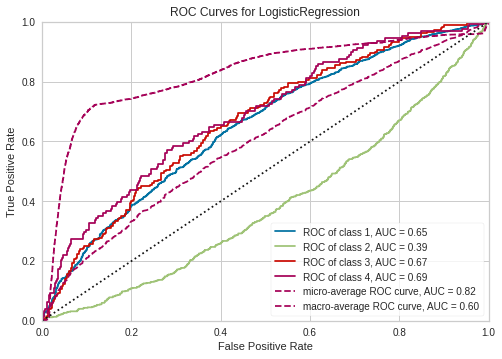

In [ ]:
visualizer = ROCAUC(logreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

#Feature Importance


In [ ]:
cols = X_train.columns.tolist()
feature_importance = pd.DataFrame(logreg.coef_.T, columns = [1,2,3,4], index=cols)
feature_importance


,1,2,3,4
RATCAT_A,0.017872,-0.016123,-0.005317,0.025888
INCGRP_A,-0.030203,0.009862,-0.192836,0.033748
INCTCFLG_A,-0.160460,0.186776,-0.883219,-0.038783
GADCAT_A,0.428216,-0.986482,0.349349,-0.351337
PCNTADTWFP_A,0.000000,-0.129148,-0.276706,0.183119
...,...,...,...,...
MHTPYNOW_A_10.0,0.000000,0.000000,0.000000,-0.052775
POVRATTC_A,0.000000,0.000000,0.000000,0.000000
INTV_QRT,0.000000,0.000000,0.000000,0.000000
FAMINCTC_A,0.000000,0.000000,-0.076487,0.000000


In [ ]:
feature_importance.sort_values(by=4, ascending=False)

,1,2,3,4
LEUKEAGETC_A_55.0,0.0,0.000000,0.000000,10.150664
UTERUAGETC_A_53.0,0.0,0.000000,0.000000,7.309624
THYROAGETC_A_65.0,0.0,0.000000,0.000000,6.680261
EMPDYSMSS2_A_13.0,0.0,-0.380611,0.000000,6.493886
HICOSTR1_A_3264.0,0.0,0.000000,1.462655,6.122861
...,...,...,...,...
SPOUSAGETC_A_26.0,0.0,0.117359,0.731919,-3.114204
EDUC_A_99,0.0,0.365854,-0.698594,-3.627518
ARTHEV_A_9,0.0,0.000000,0.000000,-4.036638
PLN1PAY5_A_1.0,0.0,0.000000,0.002817,-4.368003


In [ ]:
rfecv = RFECV(
    estimator=logreg,
    step=100,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=1
)

rfecv.fit(X_train, y_train.values.ravel())

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.grid_scores_) + 1),
    rfecv.grid_scores_,
)
plt.show()

#More Clean Data!

In [10]:
logreg = LogisticRegression(penalty = 'l1', class_weight='balanced', multi_class='ovr', solver='liblinear')
logreg.fit(X_train,y_train.values.ravel())

LogisticRegression(class_weight='balanced', multi_class='ovr', penalty='l1',
                   solver='liblinear')

In [ ]:
scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring = 'roc_auc_ovr')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
print(mean(scores))

0.8775048213156119


In [ ]:
print(metrics.classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           1       0.93      0.93      0.93      4562
           2       0.40      0.39      0.40       637
           3       0.26      0.28      0.27       220
           4       0.41      0.46      0.44       137

    accuracy                           0.83      5556
   macro avg       0.50      0.52      0.51      5556
weighted avg       0.83      0.83      0.83      5556



C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


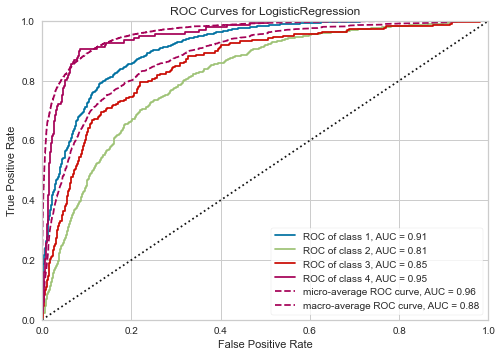

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [10]:
visualizer = ROCAUC(logreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# On reduced data

In [28]:
X_train_reduced = pd.read_csv (path + 'X_train_reduced.csv')
X_test_reduced = pd.read_csv (path + 'X_test_reduced.csv')

In [32]:
logreg = LogisticRegression(penalty = 'elasticnet', class_weight='balanced', multi_class='ovr', solver='saga', l1_ratio=0.5)
logreg.fit(X_train_reduced,y_train)

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', l1_ratio=0.5, multi_class='ovr',
                   penalty='elasticnet', solver='saga')

In [33]:
print(metrics.classification_report(y_test, logreg.predict(X_test_reduced)))

              precision    recall  f1-score   support

           1       0.89      0.67      0.76      4562
           2       0.13      0.05      0.08       637
           3       0.05      0.10      0.07       220
           4       0.06      0.58      0.10       137

    accuracy                           0.57      5556
   macro avg       0.28      0.35      0.25      5556
weighted avg       0.75      0.57      0.64      5556



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


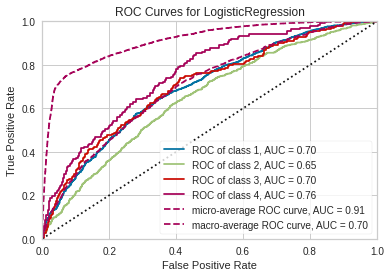

In [ ]:
visualizer = ROCAUC(logreg)
visualizer.fit(X_train_reduced, y_train)
visualizer.score(X_test_reduced, y_test)
visualizer.show()

In [7]:
from joblib import dump


In [9]:
dump(logreg, 'Logreg.joblib')

['Logreg.joblib']

No GAD

In [15]:
cols_GAD = X_train.columns[X_train.columns.str.contains('GAD')]
X_train_GAD = X_train.drop(columns=cols_GAD)
#X_train_GAD = X_train.to_numpy()


cols_GAD = X_test.columns[X_test.columns.str.contains('GAD')]
X_test_GAD = X_test.drop(columns=cols_GAD)
#X_test = X_test.to_numpy()

In [36]:
#set up paramter grid
n_features = X_train_GAD.shape[0]
param_grid = {
     'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['none', 'l1', 'l2'],
    'C' : loguniform(1e-5, 100)}

clf = RandomizedSearchCV(LogisticRegression(), param_grid, n_iter=15, scoring='roc_auc_ovr_weighted', cv=5)
clf = clf.fit(X_train_GAD, y_train.values.ravel())
print("Best estimator found by grid search:")
print(clf.best_estimator_)

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

Best estimator found by grid search:
LogisticRegression(C=0.010033323663202058, solver='newton-cg')


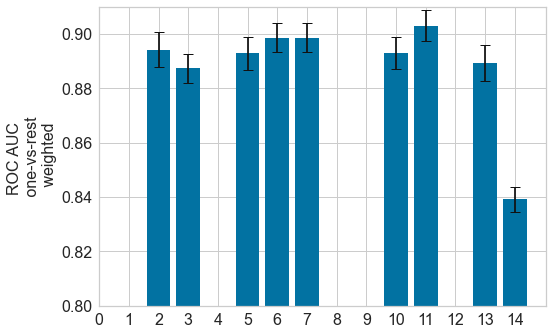

In [45]:
#gather scores for each CV iteration 
cv_res = pd.DataFrame(clf.cv_results_)
scores = cv_res.loc[:, cv_res.columns[cv_res.columns.str.contains('split')].tolist()]

path = 'RFC_opt_noGAD.csv'
cv_res.to_csv(path)

#make bar graph of scores per model
model_names=[]
for model in scores.index:
    plt.bar(model, np.mean(scores.iloc[model]), color ='b')
    plt.errorbar(model, np.mean(scores.iloc[model]), yerr=np.std(scores.iloc[model]), capsize=5, markeredgewidth=1, color='k')
    model_names.append(str(model))
plt.xticks(scores.index, model_names, fontsize=16)    
plt.ylim(bottom=0.8, top=0.91)
plt.yticks(fontsize=16)
plt.ylabel('Model', fontsize=16)
plt.ylabel('ROC AUC \n one-vs-rest \n weighted', fontsize=16)
    
plt.show()

In [39]:
logreg_GAD = LogisticRegression(penalty = 'l2', class_weight='balanced', multi_class='ovr', solver='newton-cg', C=0.010033323663202058)
logreg_GAD.fit(X_train_GAD,y_train.values.ravel())

LogisticRegression(C=0.010033323663202058, class_weight='balanced',
                   multi_class='ovr', solver='newton-cg')

In [47]:
roc_auc = roc_auc_score(y_test, logreg_GAD.predict_proba(X_test_GAD), multi_class='ovr', average='weighted')
print(roc_auc)

dump(logreg_GAD, 'LogReg_GAD.joblib')

0.8932196966269942


['LogReg_GAD.joblib']

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


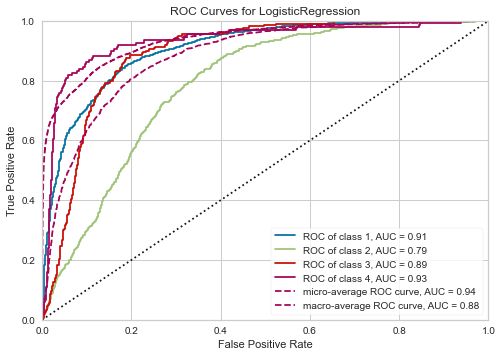

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [56]:
visualizer = ROCAUC(logreg_GAD)
visualizer.fit(X_train_GAD, y_train)
visualizer.score(X_test_GAD, y_test)
visualizer.show()

Final Logistic Regression

In [46]:
#set up paramter grid
n_features = X_train.shape[0] 
param_grid = {
     'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['none', 'l1', 'l2'],
    'C' : loguniform(1e-5, 1)}

clf = RandomizedSearchCV(LogisticRegression(), param_grid, n_iter=15, scoring='roc_auc_ovr_weighted', cv=5)
clf = clf.fit(X_train, y_train.values.ravel())
print("Best estimator found by grid search:")
print(clf.best_estimator_)

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

Best estimator found by grid search:
LogisticRegression(C=0.0035940117362735723)


C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
logreg = LogisticRegression(penalty = 'l2', class_weight='balanced', multi_class='ovr', solver='newton-cg', C=0.0035940117362735723)
logreg.fit(X_train,y_train)

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.0035940117362735723, class_weight='balanced',
                   multi_class='ovr', solver='newton-cg')

In [54]:
dump(logreg, 'LogReg_final.joblib')

['LogReg_final.joblib']

In [48]:
#TABLE OF RESULTS
cv_res = pd.DataFrame(clf.cv_results_)
#save data
path = 'LogReg_opt.csv'
cv_res.to_csv(path)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.408369,0.140675,0.000000,0.000000,0.028817,l1,lbfgs,"{'C': 0.028817337814925202, 'penalty': 'l1', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,1108.189839,79.620718,0.155819,0.011503,0.127515,l2,newton-cg,"{'C': 0.1275147584480443, 'penalty': 'l2', 'so...",0.918776,0.917475,0.915358,0.913403,0.914673,0.915937,0.001938,5
2,0.364108,0.048521,0.000000,0.000000,0.000517,l1,newton-cg,"{'C': 0.0005170106853626883, 'penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
3,518.792815,81.222297,0.144727,0.008505,0.065425,l2,newton-cg,"{'C': 0.06542467587915461, 'penalty': 'l2', 's...",0.922581,0.920939,0.919890,0.916860,0.918578,0.919770,0.001958,4
4,20.812116,0.653443,0.140375,0.005991,0.019897,l2,lbfgs,"{'C': 0.019897278806396083, 'penalty': 'l2', '...",0.928862,0.923994,0.923752,0.920227,0.926967,0.924761,0.002961,3
5,21.010661,0.437995,0.141260,0.010163,0.003594,l2,lbfgs,"{'C': 0.0035940117362735723, 'penalty': 'l2', ...",0.929439,0.924215,0.924993,0.921310,0.927015,0.925394,0.002728,1
6,0.339303,0.013575,0.000000,0.000000,0.026208,none,liblinear,"{'C': 0.026208087366824947, 'penalty': 'none',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
7,20.074771,0.776223,0.139988,0.007505,0.000046,none,lbfgs,"{'C': 4.588408995488392e-05, 'penalty': 'none'...",0.928406,0.924510,0.925409,0.920368,0.926667,0.925072,0.002691,2
8,1506.860914,119.811564,0.154922,0.006457,0.006123,none,newton-cg,"{'C': 0.006122644534663268, 'penalty': 'none',...",0.818413,0.814592,0.814463,0.828594,0.819591,0.819131,0.005151,10
9,19.826819,0.458899,0.133034,0.001804,0.000152,l2,lbfgs,"{'C': 0.00015229812639029616, 'penalty': 'l2',...",0.919271,0.914182,0.918292,0.911654,0.914559,0.915592,0.002807,7


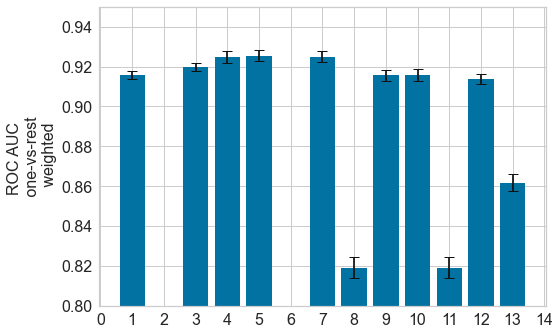

In [49]:
#GRAPH CV RESULTS

#gather scores for each CV iteration 
scores = cv_res.loc[:, cv_res.columns[cv_res.columns.str.contains('split')].tolist()]

#make bar graph of scores per model
model_names=[]
for model in scores.index:
    plt.bar(model, np.mean(scores.iloc[model]), color ='b')
    plt.errorbar(model, np.mean(scores.iloc[model]), yerr=np.std(scores.iloc[model]), capsize=5, markeredgewidth=1, color='k')
    model_names.append(str(model))
plt.xticks(scores.index, model_names, fontsize=16)    
plt.ylim(bottom=0.8, top=0.95)
plt.yticks(fontsize=16)
plt.ylabel('Model', fontsize=16)
plt.ylabel('ROC AUC \n one-vs-rest \n weighted', fontsize=16)
    
plt.show()

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


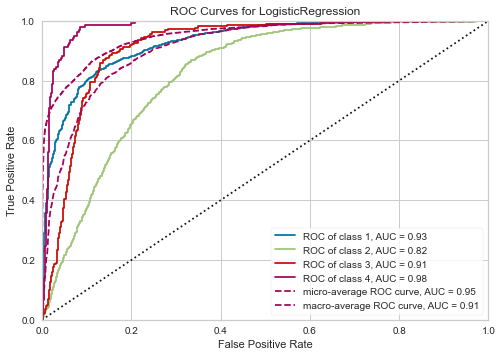

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
visualizer = ROCAUC(logreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [55]:
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr', average='weighted')
print(roc_auc)

0.9176006671610951
